# Densified Model for Shoal and Waller Creek Watersheds 

Modified from [Dr. Matt Bartos](https://github.com/mdbartos) code ["run_densified_model_with_forcings.ipynb"](https://github.com/future-water/cuahsi-summer-institute-2025/blob/main/notebooks/run_densified_model_with_forcings.ipynb) and ["run_model_collection_with_da.ipynb"](https://github.com/future-water/cuahsi-summer-institute-2025/blob/main/notebooks/run_model_collection_with_da.ipynb) located in [cuahsi-summer-institute-2025](https://github.com/future-water/cuahsi-summer-institute-2025/tree/main) repository. 

Modifications completed by [Victor Oladoja](https://github.com/oladojavictor) and [Megan Vardaman](https://github.com/Megan-Verf) as part of [2025 Water Prediction Innovators Summer Institute Program](https://www.cuahsi.org/summer-institute). 

Team Name: DensiFIMcation 

Members: Victor Oladoja, Alex Simpson, Megan Vardaman

# Import modules

In [273]:
import sys
sys.path.append('../../tx-fast-hydrology')

In [274]:
import datetime
import itertools
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import dataretrieval.nwis as nwis
from tx_fast_hydrology.muskingum import Muskingum, ModelCollection, Connection
from tx_fast_hydrology.simulation import AsyncSimulation
from tx_fast_hydrology.da import KalmanFilter

# Define region and time period of interest 

Assumes model has already been partitioned into submodel sections (see ["subset_waller_and_shoal_densified.ipynb"](https://github.com/future-water/cuahsi-summer-institute-2025/blob/main/notebooks/subset_waller_and_shoal_densified.ipynb)) and that NWM output data has already been downloaded and converted to .hdf for the selected dates (see ["nwm_data_loader.py"](https://github.com/future-water/cuahsi-summer-institute-2025/blob/main/utils/nwm_data_loader.py) and ["rewrite_h5_files.py"](https://github.com/future-water/cuahsi-summer-institute-2025/blob/main/utils/rewrite_h5_files.py)). 

# Select dates

In [278]:
# Define time period 
startdate = '20220822'
enddate = '20220824'

startdate_string = format(pd.to_datetime(startdate, format = '%Y%m%d'), '%Y-%m-%d')
enddate_string = format(pd.to_datetime(enddate, format = '%Y%m%d'), '%Y-%m-%d')

# Date range to load
date_list = pd.date_range(startdate, enddate, freq='h', tz='utc')[:-1]

# Define path for NWM forcings
forcing_path = '../../densifimcation_shared/forcing/'+ startdate +'_event'

# Load model collection

In [286]:
# Define model file input path
input_path = '../../DensiFIMcation/data/shoal_waller_nwm.json'
# input_path = '../../DensiFIMcation/data/shoal_waller_less_densified.json'

# Load model collection from file
model_collection = ModelCollection.from_file(input_path)

In [ ]:
if input_path == '../../DensiFIMcation/data/shoal_waller_nwm.json': 
    # Define watershed 
    ws = 'shoal_waller_nwm' 
    ws_string = 'Shoal and Waller Creek (NWM)' 
    mtd = '120s'
elif input_path == '../../DensiFIMcation/data/shoal_waller_less_densified.json': 
    # Define watershed 
    ws = 'shoal_waller_den' 
    ws_string = 'Shoal and Waller Creek (densified)' 
    mtd = '20s'
elif input_path == '../../densifimcation_shared/data/shoal_densified.json': 
    # Define watershed 
    ws = 'shoal_more_den' 
    ws_string = 'Shoal Creek (more densified)' 

Text(0.5, 1.0, 'NWM')

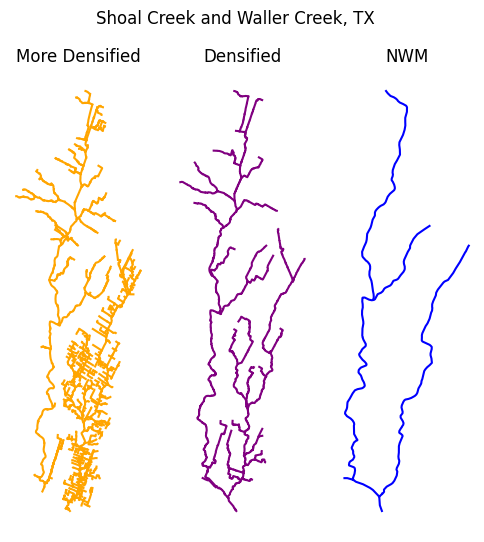

In [288]:
# Plot Shoal and Waller Creek
# Read dumped model files
waller_densified = ModelCollection.from_file('../../densifimcation_shared/data/waller_densified.json')
shoal_densified = ModelCollection.from_file('../../densifimcation_shared/data/shoal_densified.json')
shoal_less_densified = ModelCollection.from_file('../../DensiFIMcation/data/shoal_waller_less_densified.json')
shoal_nwm = ModelCollection.from_file('../../DensiFIMcation/data/shoal_waller_nwm.json')

fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(6,6))
for model_name, model in waller_densified.models.items():
    model.plot(ax=ax, c='orange')
for model_name, model in shoal_densified.models.items():
    model.plot(ax=ax, c='orange')
for model_name, model in shoal_less_densified.models.items():
    model.plot(ax=ax1, c='purple')
for model_name, model in shoal_nwm.models.items():
    model.plot(ax=ax2, c='blue')
ax.axis('off')
ax1.axis('off')
ax2.axis('off')

plt.suptitle('Shoal Creek and Waller Creek, TX')
ax.set_title('More Densified')
ax1.set_title('Densified')
ax2.set_title('NWM')

# Create model inputs

### Load NWM forcings

In [289]:
# Required NWM variables
nwm_vars = ['qBucket', 'qSfcLatRunoff', 'streamflow']

# Loop through HDF5 files and load forcings into memory
streamflows = []
runoffs = []
buckets = []
for date in date_list:
    date_str = date.strftime('%Y%m%d%H')
    streamflow = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__streamflow')
    runoff = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__qSfcLatRunoff')
    bucket = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__qBucket')
    streamflows.append(streamflow)
    runoffs.append(runoff)
    buckets.append(bucket)
# Concatenate all forcings into single dataframe
streamflow = pd.concat(streamflows)
runoff = pd.concat(runoffs)
bucket = pd.concat(buckets)
# Lateral inflow at each reach is equal to runoff plus bucket recharge
forcing = runoff + bucket

# Ensure no duplicate entries
forcing = forcing.groupby(level=0).mean()
streamflow = streamflow.groupby(level=0).mean()

# Format column types
forcing.columns = forcing.columns.astype(str)
streamflow.columns = forcing.columns.astype(str)

### Optional: Reset Model Timedelta

In [ ]:
# IMPLICATIONS OF THIS PROCESS ON MODEL RESULTS ARE UNCERTAIN 
if input_path == '../../DensiFIMcation/data/shoal_waller_less_densified.json': 
    for model in model_collection.models.values():
        # change the timestep
        model.timedelta = pd.to_timedelta(mtd)
        model.compute_muskingum_coeffs()
        #print(model.timedelta)
else: 
    for model in model_collection.models.values():
        print(model.timedelta.seconds)

120


### Create inputs to model based on forcings

In [ ]:
# Create input table with lateral overflow into each modeled reach
input_columns = list(itertools.chain.from_iterable([model.reach_ids for model 
                                                    in model_collection.models.values()]))
input_index = forcing.index.copy()
inputs = pd.DataFrame(0., index=input_index, columns=input_columns)

a = []
# Fill input table with forcings for each reach
if input_path == '../../DensiFIMcation/data/shoal_waller_nwm.json':                                        

    # Fill input table with forcings for each reach
    for col in inputs.columns:
        if col in forcing.columns:
            inputs[col] = forcing[col]


elif input_path == '../../DensiFIMcation/data/shoal_waller_less_densified.json':

    store = pd.HDFStore('../../densifimcation_shared/data/area_fractions_shoalwaller.h5', 'r')
    hdf_keys = store.keys()
    store.close()
    for key in hdf_keys:
        comid = key.split('__')[-1]        
        area_ratios = pd.read_hdf(f'../../densifimcation_shared/data/area_fractions_shoalwaller.h5', key=key)
        for reach_id in area_ratios.index:
            if comid in forcing.columns:
                runoff_proportion = area_ratios.loc[reach_id].item() * forcing[comid]
                reach_id_str = str(reach_id)
                a.append(reach_id_str)
                if reach_id_str in inputs.columns:
                    inputs[reach_id_str] += runoff_proportion

# NOT NEEDED FOR SHOAL AND WALLER CREEK AREAS -- NO UPSTREAM INPUTS 
# Add inflow to upstream boundary reaches
# upstream_inputs = {
#     '5779305' : '5781161',
#     '5785187' : '5785899',
#     '5786029' : '5785351'
# }
# for downstream_reach, upstream_reach in upstream_inputs.items():
#     inputs[downstream_reach] += streamflow[upstream_reach]

In [292]:
# Resample forcing input table to frequency of model timestep
dt = model_collection.timedelta.seconds
print('Model timedelta is ' + str(dt) + ' seconds') 
inputs = inputs.resample(f'{dt}s').mean()
inputs = inputs.interpolate().bfill().ffill()
assert not inputs.isnull().any().any()

Model timedelta is 120 seconds


# Gather gage measurements for event period

### From USGS DataRetrieval Package

In [293]:
# Load table of mappings from USGS Gage IDs to NWM COMIDs
if input_path == '../../DensiFIMcation/data/shoal_waller_nwm.json':
    usgs_to_densified_reach_df = pd.read_csv('../../densifimcation_shared/data/usgs_to_comid.csv', index_col=0) 
    usgs_to_densified_reach_df = usgs_to_densified_reach_df[['gage_id','comid']].reset_index(drop=True).dropna().reset_index(drop=True)
    usgs_to_densified_reach_df['gage_id'] = usgs_to_densified_reach_df['gage_id'].astype(int).astype(str)
    usgs_to_densified_reach_df['reach_id'] = usgs_to_densified_reach_df['comid'].astype(int).astype(str)
    # Filter 
    usgs_to_densified_reach_df = usgs_to_densified_reach_df[usgs_to_densified_reach_df['reach_id'].isin(input_columns)]
    # Prepare gage IDs for USGS dataretrieval 
    sites = usgs_to_densified_reach_df.gage_id.dropna().astype(int).astype(str).reset_index(drop = True)
    site_ids = []
    for i in sites: 
        site_ids.append(i.zfill(8)) # add leading zeros to gage IDs 
    print('Number of gages: ' + str(len(site_ids)))

    # Get site info 
    TCsites = nwis.what_sites(sites = site_ids, startDT=startdate_string, endDT=enddate_string, parameterCd="00060")
    # print(TCsites[0].head())

    # Convert to series 
    usgs_to_densified_reach = pd.Series(usgs_to_densified_reach_df['reach_id'].values, index=usgs_to_densified_reach_df['gage_id'].values)

elif input_path == '../../DensiFIMcation/data/shoal_waller_less_densified.json':
    usgs_to_densified_reach_df = pd.read_csv('../../DensiFIMcation/data/NWPSGages_Shoal_Waller_to_Less_Densified.csv', index_col=0) 
    usgs_to_densified_reach_df = usgs_to_densified_reach_df[['usgs_id','HydroID']].reset_index(drop=True).dropna().reset_index(drop=True)
    usgs_to_densified_reach_df['usgs_id'] = usgs_to_densified_reach_df['usgs_id'].astype(int).astype(str)
    usgs_to_densified_reach_df['reach_id'] = usgs_to_densified_reach_df['HydroID'].astype(int).astype(str)
    # Filter 
    usgs_to_densified_reach_df = usgs_to_densified_reach_df[usgs_to_densified_reach_df['reach_id'].isin(input_columns)]
    # Prepare gage IDs for USGS dataretrieval 
    sites = usgs_to_densified_reach_df.usgs_id.dropna().astype(int).astype(str).reset_index(drop = True)
    # sites = usgs_to_comid.usgs_id.dropna().astype(int).astype(str).reset_index(drop = True)
    site_ids = []
    for i in sites: 
        site_ids.append(i.zfill(8)) # add leading zeros to gage IDs 
    print('Number of gages: ' + str(len(site_ids)))

    # Get site info 
    TCsites = nwis.what_sites(sites = site_ids, startDT=startdate_string, endDT=enddate_string, parameterCd="00060")
    # print(TCsites[0].head())

    # Convert to series 
    usgs_to_densified_reach = pd.Series(usgs_to_densified_reach_df['reach_id'].values, index=usgs_to_densified_reach_df['usgs_id'].values)
    usgs_to_densified_reach = usgs_to_densified_reach.drop('8157560') # drop gage with missing data 


Number of gages: 4


20220822
20220824
08157540
08156675
08156910
08156800


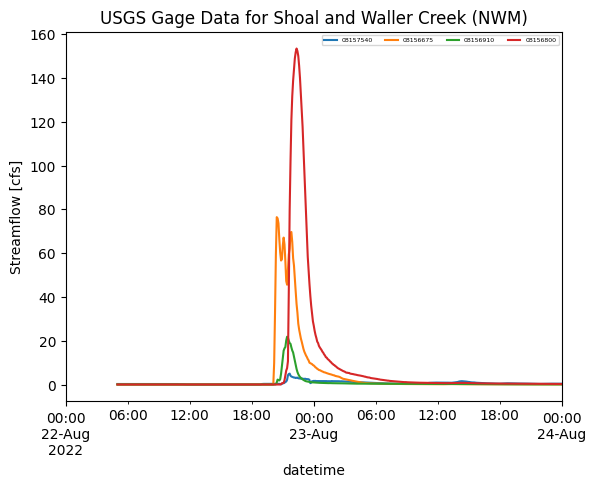

In [294]:
# Restructure data for h5 file 
eventdata = [] 
print(startdate)
print(enddate)

for i in list(set(site_ids)): 
    print(i)
    # fig, ax = plt.subplots()
    df = nwis.get_iv(sites=i, start=startdate_string, end=enddate_string, parameterCd='00060')
    df = pd.DataFrame(df[0])
    if len(df.columns) == 3 and len(df) > 0: 
        df.columns = ['site_no', '00060', 'sensor_cd']
        # print(df.columns)
        # ax.plot(df.index, df['00060']) #df['00060_primary sensor'])
        df1 = pd.DataFrame(df['00060'])
        df1.columns = [i]
        eventdata.append(df1)
    else: 
        # ax.plot(df.index, df.iloc[:,1])
        print(i)
        print(df)
        # df1 = pd.DataFrame(df.iloc[:,1])
    # plt.suptitle(i)
    # plt.show()

# Concatenate event data 
df2 = (pd.concat(eventdata, axis = 1))

# Convert cfs to cms 
df3 = df2*0.02831683199881

# Plot data 
df3.plot()
plt.title('USGS Gage Data for ' + ws_string)
plt.ylabel('Streamflow [cfs]')
plt.legend(ncol = 8, loc = 'upper right', prop = {'size' : 4.5})
plt.xlim(startdate, enddate)

# Export data to hdf 
df3.loc[:, ~df3.columns.duplicated()].to_hdf('../../densifimcation_shared/data/gage_data_usgs/gages_usgs_'+ startdate +'_to_'+ enddate +'_' + ws + '.h5', key = 'usgs', mode = 'w')

#### Load USGS dataretrieval output

In [295]:
# Load table of USGS gage measurements
# measurements = pd.read_hdf('../../cuahsi-summer-institute-2025/data/gages.h5', key='usgs') # Original file from Matt Bartos 
measurements = pd.read_hdf('../../densifimcation_shared/data/gage_data_usgs/gages_usgs_' + startdate + '_to_' + enddate + '_' + ws + '.h5', key = 'usgs') # New file created from dataretrieval 
measurements.columns = measurements.columns.astype(int).astype(str)

# Filter measurements to those with associated COMIDs
measurements = measurements[usgs_to_densified_reach.index]
measurements.columns = measurements.columns.map(usgs_to_densified_reach)
measurements = measurements.loc[forcing.index[0]:forcing.index[-1]]
measurements = measurements.dropna(axis=1)
measurements = measurements.loc[:, ~(measurements == 0.).all(axis=0).values]
measurements = measurements.loc[:, ~measurements.columns.duplicated()].copy()
measurements = measurements.resample(f'{dt}s').mean().interpolate().ffill().bfill()

#### Load original gages file provided by Matt Bartos (optional: alternative to USGS dataretrival method) 

In [252]:
# # Load table of mappings from USGS Gage IDs to NWM COMIDs
# usgs_to_densified_reach = pd.read_csv('../../cuahsi-summer-institute-2025/data/usgs_reach_id_densified.csv', index_col=0) 
# usgs_to_densified_reach = usgs_to_densified_reach[['usgs_id','reach_id']].reset_index(drop=True).dropna().reset_index(drop=True)
# usgs_to_densified_reach['usgs_id'] = usgs_to_densified_reach['usgs_id'].astype(int).astype(str)
# usgs_to_densified_reach['reach_id'] = usgs_to_densified_reach['reach_id'].astype(int).astype(str)
# # Filter 
# usgs_to_densified_reach = usgs_to_densified_reach[usgs_to_densified_reach['reach_id'].isin(input_columns)]
# usgs_to_densified_reach = pd.Series(usgs_to_densified_reach['reach_id'].values, index=usgs_to_densified_reach['usgs_id'].values)
# # usgs_to_densified_reach.drop(['8154900', '8154500'], inplace=True)


# # Load table of USGS gage measurements
# measurements = pd.read_hdf('../../cuahsi-summer-institute-2025/data/gages.h5', key='usgs')
# measurements.columns = measurements.columns.astype(int).astype(str)
# measurements = measurements[usgs_to_densified_reach.index]
# measurements.columns = measurements.columns.map(usgs_to_densified_reach)
# measurements = measurements.loc[forcing.index[0]:forcing.index[-1]]
# measurements = measurements.dropna(axis=1)
# measurements = measurements.loc[:, ~(measurements == 0.).all(axis=0).values]
# measurements = measurements.loc[:, ~measurements.columns.duplicated()].copy()
# measurements = measurements.resample(f'{dt}s').mean().interpolate().ffill().bfill()

# Set up Kalman Filter

In [296]:
# Set up Kalman Filtering
for model in model_collection.models.values():
    # Find subset of gages for each sub-model
    model_sites = [reach_id for reach_id in model.reach_ids 
                    if reach_id in measurements.columns]
    if model_sites:
        # Get subset of measurements for sub-model
        basin_measurements = measurements[model_sites]
        # Process noise covariance matrix
        Q_cov = 1. * np.eye(model.n) # how much confindence in the model vs measurements...if the Q_cov is small, we are trust the model
        # Measurement noise covariance matrix
        R_cov = 1. * np.eye(basin_measurements.shape[1])
        # Initial estimate of error covariance matrix
        P_t_init = Q_cov.copy()
        # Create Kalman Filter
        kf = KalmanFilter(model, basin_measurements, Q_cov, R_cov, P_t_init)
        # Bind Kalman Filter to model
        model.bind_callback(kf, key='kf')

# Prepare and execute simulation with Data Assimilation (DA)

### Prepare model for simulation

In [297]:
# Add downstream boundaries to model
for model in model_collection.models.values():
    if not model.sinks:
        outlet = model.startnodes[model.startnodes == model.endnodes].item()
        model.set_transmissive_boundary(outlet)

# Set starting time of each model to just before start of forcings
timedelta = pd.to_timedelta(dt, unit='s')
for model_name, model in model_collection.models.items():
    model.datetime = inputs.index[0] - timedelta

# Set up simulation
simulation = AsyncSimulation(model_collection, inputs)

### Simulate model

In [298]:
starttime = datetime.datetime.now()
# Simulate models
outputs_da = await simulation.simulate()
endtime = datetime.datetime.now()
# Collect outputs into a single table
outputs_da = pd.concat([series for series in outputs_da.values()], axis=1)
print(f"the code took {endtime-starttime} to run")

the code took 0:00:00.736524 to run


# Test Forecast Approach 
Based on code prepared by Jeil Oh 

In [89]:
# Required NWM variables
nwm_vars = ['qBucket', 'qSfcLatRunoff', 'streamflow']

# Loop through HDF5 files and load forcings into memory
streamflows = []
runoffs = []
buckets = []
for date in date_list:
    print(date)
    date_str = date.strftime('%Y%m%d%H')
    streamflow = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='short_range__streamflow')
    runoff = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='short_range__qSfcLatRunoff')
    bucket = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='short_range__qBucket')
    streamflows.append(streamflow)
    runoffs.append(runoff)
    buckets.append(bucket)
# Concatenate all forcings into single dataframe
streamflow = pd.concat(streamflows)
runoff = pd.concat(runoffs)
bucket = pd.concat(buckets)
# Lateral inflow at each reach is equal to runoff plus bucket recharge
forcing = runoff + bucket

# Ensure no duplicate entries
forcing = forcing.groupby(level=0).mean()
streamflow = streamflow.groupby(level=0).mean()

# Format column types
forcing.columns = forcing.columns.astype(str)
streamflow.columns = forcing.columns.astype(str)

2022-08-22 00:00:00+00:00
2022-08-22 01:00:00+00:00
2022-08-22 02:00:00+00:00
2022-08-22 03:00:00+00:00
2022-08-22 04:00:00+00:00
2022-08-22 05:00:00+00:00
2022-08-22 06:00:00+00:00
2022-08-22 07:00:00+00:00
2022-08-22 08:00:00+00:00
2022-08-22 09:00:00+00:00
2022-08-22 10:00:00+00:00
2022-08-22 11:00:00+00:00
2022-08-22 12:00:00+00:00
2022-08-22 13:00:00+00:00
2022-08-22 14:00:00+00:00
2022-08-22 15:00:00+00:00
2022-08-22 16:00:00+00:00
2022-08-22 17:00:00+00:00
2022-08-22 18:00:00+00:00
2022-08-22 19:00:00+00:00
2022-08-22 20:00:00+00:00
2022-08-22 21:00:00+00:00
2022-08-22 22:00:00+00:00
2022-08-22 23:00:00+00:00
2022-08-23 00:00:00+00:00
2022-08-23 01:00:00+00:00
2022-08-23 02:00:00+00:00
2022-08-23 03:00:00+00:00
2022-08-23 04:00:00+00:00
2022-08-23 05:00:00+00:00
2022-08-23 06:00:00+00:00
2022-08-23 07:00:00+00:00
2022-08-23 08:00:00+00:00
2022-08-23 09:00:00+00:00
2022-08-23 10:00:00+00:00
2022-08-23 11:00:00+00:00
2022-08-23 12:00:00+00:00
2022-08-23 13:00:00+00:00
2022-08-23 1

In [90]:
# Create input table with lateral overflow into each modeled reach
input_columns = list(itertools.chain.from_iterable([model.reach_ids for model 
                                                    in model_collection.models.values()]))
input_index = forcing.index.copy()
inputs = pd.DataFrame(0., index=input_index, columns=input_columns)

# Fill input table with forcings for each reach
store = pd.HDFStore('../../cuahsi-summer-institute-2025/data/area_fractions.h5', 'r')
hdf_keys = store.keys()
store.close()
for key in hdf_keys:
    comid = key.split('__')[-1]
    area_ratios = pd.read_hdf(f'../../cuahsi-summer-institute-2025/data/area_fractions.h5', key=key)
    for reach_id in area_ratios.index:
        if comid in forcing.columns:
            runoff_proportion = area_ratios.loc[reach_id].item() * forcing[comid]
            reach_id_str = str(reach_id)
            if reach_id_str in inputs.columns:
                inputs[reach_id_str] += runoff_proportion

# NOT NEEDED FOR SHOAL AND WALLER CREEK AREAS -- NO UPSTREAM INPUTS 
# Add inflow to upstream boundary reaches
# upstream_inputs = {
#     '5779305' : '5781161',
#     '5785187' : '5785899',
#     '5786029' : '5785351'
# }
# for downstream_reach, upstream_reach in upstream_inputs.items():
#     inputs[downstream_reach] += streamflow[upstream_reach]

In [91]:
# Resample forcing input table to frequency of model timestep
dt = model_collection.timedelta.seconds
print(dt)
inputs = inputs.resample(f'{dt}s').mean()
inputs = inputs.interpolate().bfill().ffill()
assert not inputs.isnull().any().any()

10


In [84]:
for date in date_list:
    date_str = date.strftime('%Y%m%d%H')
    print(date)
    if hasattr(model, 'callbacks') and 'kf' in model.callbacks:
            measurement_timestep = date
            measurements_columns = model.callbacks['kf'].measurements.columns
            print(model.callbacks['kf'].measurements)
            model.callbacks['kf'].measurements = basin_measurements.loc[[measurement_timestep], measurements_columns]
        
    for model in model_collection.models.values():
        outlet = model.startnodes[model.startnodes == model.endnodes].item()
        model.set_transmissive_boundary(outlet)

    timedelta = pd.to_timedelta(dt, unit='s')
    for model_name, model in model_collection.models.items():
        model.datetime = inputs.index[0] - pd.to_timedelta('1h')

    simulation = AsyncSimulation(model_collection, inputs)
    outputs = await simulation.simulate()
    all_outputs_da[date_str] = pd.concat([series for series in outputs.values()], axis=1)

2022-08-22 00:00:00+00:00
                            2360775   2382255
datetime                                     
2022-08-22 05:00:00+00:00  0.009345  0.000000
2022-08-22 05:00:10+00:00  0.009345  0.000000
2022-08-22 05:00:20+00:00  0.009345  0.000000
2022-08-22 05:00:30+00:00  0.009345  0.000000
2022-08-22 05:00:40+00:00  0.009345  0.000000
...                             ...       ...
2022-08-23 22:59:20+00:00  0.282111  0.061901
2022-08-23 22:59:30+00:00  0.282092  0.061787
2022-08-23 22:59:40+00:00  0.282073  0.061674
2022-08-23 22:59:50+00:00  0.282055  0.061561
2022-08-23 23:00:00+00:00  0.282036  0.061448

[15121 rows x 2 columns]


KeyError: "None of [DatetimeIndex(['2022-08-22 00:00:00+00:00'], dtype='datetime64[ns, UTC]', name='datetime', freq=None)] are in the [index]"

In [85]:
def load_nwm_data(forcing_path, date):
    date_str = date.strftime('%Y%m%d%H')
    streamflow = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='short_range__streamflow')
    runoff = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='short_range__qSfcLatRunoff')
    bucket = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='short_range__qBucket')


    forcing = runoff + bucket
    return streamflow, forcing

In [87]:
all_outputs_da = {}
for date in date_list:
    date_str = date.strftime('%Y%m%d%H')
    model_collection.load_states()
    
    streamflow, forcing = load_nwm_data(forcing_path, date)
    forcing.columns = forcing.columns.astype(str)
    streamflow.columns = forcing.columns.astype(str)
    inputs = forcing

    input_columns = list(itertools.chain.from_iterable([model.reach_ids for model 
                                                    in model_collection.models.values()]))
    input_index = forcing.index.copy()
    inputs = pd.DataFrame(0., index=input_index, columns=input_columns)

    # Fill input table with forcings for each reach
    for col in inputs.columns:
        if col in forcing.columns:
            inputs[col] = forcing[col]

    # # Add inflow to upstream boundary reaches
    # upstream_inputs = {
    #     '5779305' : '5781161',
    #     '5785187' : '5785899',
    #     '5786029' : '5785351'
    # }
    # for downstream_reach, upstream_reach in upstream_inputs.items():
    #     inputs[downstream_reach] += streamflow[upstream_reach]

    inputs.columns = inputs.columns.astype(str)
    dt = model_collection.timedelta.seconds
    inputs = inputs.resample(f'{dt}s').mean()
    inputs = inputs.interpolate().bfill().ffill()

    if hasattr(model, 'callbacks') and 'kf' in model.callbacks:
        measurement_timestep = date
        measurements_columns = model.callbacks['kf'].measurements.columns
        model.callbacks['kf'].measurements = basin_measurements.loc[[measurement_timestep], measurements_columns]
    
    for model in model_collection.models.values():
        outlet = model.startnodes[model.startnodes == model.endnodes].item()
        model.set_transmissive_boundary(outlet)

    timedelta = pd.to_timedelta(dt, unit='s')
    for model_name, model in model_collection.models.items():
        model.datetime = inputs.index[0] - pd.to_timedelta('1h')

    simulation = AsyncSimulation(model_collection, inputs)
    outputs = await simulation.simulate()
    all_outputs_da[date_str] = pd.concat([series for series in outputs.values()], axis=1)

KeyError: "None of [DatetimeIndex(['2022-08-22 00:00:00+00:00'], dtype='datetime64[ns, UTC]', name='datetime', freq=None)] are in the [index]"

# Compare results

### Run model with no data assimilation (NODA)

In [ ]:
# Load model collection from file
model_collection = ModelCollection.from_file(input_path)

for model in model_collection.models.values():
    # change the timestep
    model.timedelta = pd.to_timedelta(mtd)
    model.compute_muskingum_coeffs()
    #print(model.timedelta)

# Add downstream boundaries to model
for model in model_collection.models.values():
    if not model.sinks:
        outlet = model.startnodes[model.startnodes == model.endnodes].item()
        model.set_transmissive_boundary(outlet)

# Set starting time of each model to just before start of forcings
timedelta = pd.to_timedelta(dt, unit='s')
for model_name, model in model_collection.models.items():
    model.datetime = inputs.index[0] - timedelta

# Set up simulation
simulation = AsyncSimulation(model_collection, inputs)

starttime = datetime.datetime.now()

# Simulate models
outputs_noda = await simulation.simulate()
# Collect outputs into a single table
outputs_noda = pd.concat([series for series in outputs_noda.values()], axis=1)

endtime = datetime.datetime.now()
print(f"the code took {endtime-starttime} to run")

the code took 0:00:00.218289 to run


In [309]:
# Print number of unique IDs (individual reaches) in modeled output 
print(len(outputs_noda.columns))

9


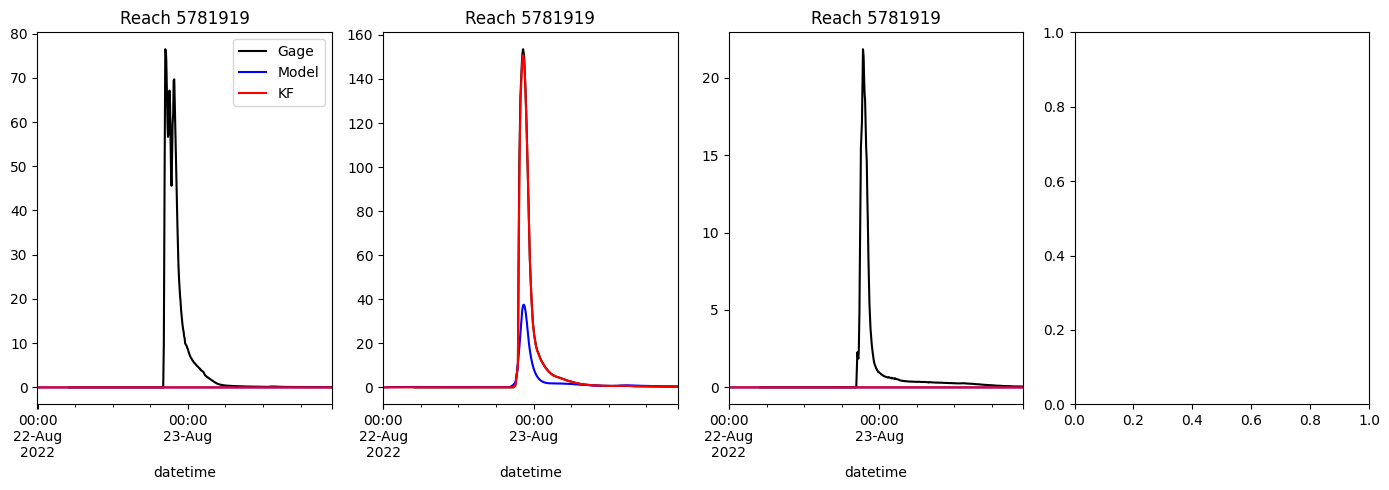

In [314]:
fig, ax = plt.subplots(1, 4, figsize=(14, 5))

for index, reach_id in enumerate(measurements.columns):
    measurements[reach_id].plot(ax=ax.flat[index], c='k', label='Gage')
    outputs_noda[reach_id].plot(ax=ax.flat[index], c='b', label='Model')
    outputs_da[reach_id].plot(ax=ax.flat[index], c='r', label='KF')
    if index < measurements.columns.size - 3:
        ax.flat[index].xaxis.set_ticklabels([])
    ax.flat[index].xaxis.set_ticklabels([], minor=True)
    ax.flat[index].set_title(f'Reach {comid}')
ax.flat[0].legend()
plt.tight_layout()

### Plot DA result vs. NODA result at gage locations

(0.0, 250.0)

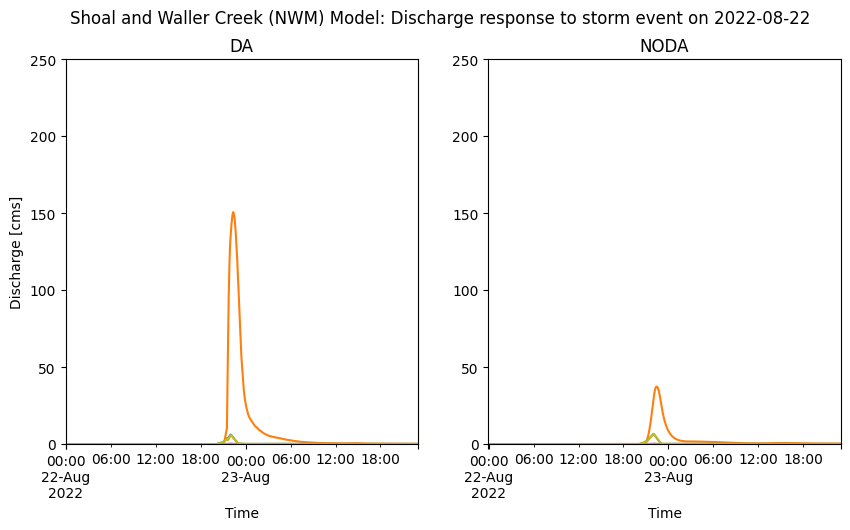

In [312]:
# Plot model output data 
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 5), sharex = True)
outputs_da.plot(ax=ax, legend=False)
outputs_noda.plot(ax=ax1, legend=False)
ax.set_title("DA")
ax1.set_title("NODA")
ax.set_xlabel('Time')
ax1.set_xlabel('Time')
ax.set_ylabel('Discharge [cms]')
fig.suptitle(ws_string + ' Model: Discharge response to storm event on ' + startdate_string)
ax.set_ylim(0,250)
ax1.set_ylim(0,250)
# plt.legend()

### Plot map of gains

In [315]:
total_gain = (outputs_da - outputs_noda).mean(axis=0)

In [323]:
input_columns

['5781313',
 '5781703',
 '5781223',
 '5781221',
 '5781907',
 '5781905',
 '5781903',
 '5781889',
 '5781887']

In [325]:
if input_path == '../../DensiFIMcation/data/shoal_waller_nwm.json': 
    den_streams_tx = gpd.read_file('../../densifimcation_shared/data/nwm_streams_tx')
    den_streams_tx['ID'] = den_streams_tx['ID'].astype(int).astype(str)
    den_streams_travis = den_streams_tx[den_streams_tx['ID'].isin(input_columns)].copy()
    den_streams_travis['gain'] = den_streams_travis['ID'].map(total_gain).fillna(0.).values
    den_streams_travis['log_gain'] = np.log(1 + np.abs(den_streams_travis['gain'].values))

elif input_path == '../../DensiFIMcation/data/shoal_waller_less_densified.json': 
    den_streams_tx = gpd.read_file('../../DensiFIMcation/data/ESRI_streamlines_trimmed')
    den_streams_tx['ID'] = den_streams_tx['GridID'].astype(int).astype(str)
    den_streams_travis = den_streams_tx[den_streams_tx['ID'].isin(input_columns)].copy()
    den_streams_travis['gain'] = den_streams_travis['ID'].map(total_gain).fillna(0.).values
    den_streams_travis['log_gain'] = np.log(1 + np.abs(den_streams_travis['gain'].values))

elif input_path == '../../densifimcation_shared/data/shoal_densified.json': 
    den_streams_tx = gpd.read_file('../../cuahsi-summer-institute-2025/data/travis_densified_streamlines')

den_streams_tx.head()

,OBJECTID,ID,to,order_,Lake,gages,Slope,Length,mainstem,Shape_Leng,geometry
0,1.0,207863,207859.0,1.0,-9999.0,None,0.00001,12324.0,0.0,0.120213,"LINESTRING (-141734.774 323386.073, -141033.05..."
1,2.0,207787,209995.0,1.0,-9999.0,None,0.00001,1137.0,0.0,0.010851,"LINESTRING (-142031.304 324674.247, -141896.93..."
2,3.0,206685,206527.0,1.0,-9999.0,None,0.00001,2390.0,0.0,0.022434,"LINESTRING (-177928.709 338165.67, -177959.955..."
3,4.0,206477,206713.0,1.0,-9999.0,None,0.00022,518.0,0.0,0.004868,"LINESTRING (-168301.28 340850.424, -168338.841..."
4,5.0,206841,210049.0,1.0,-9999.0,None,0.00001,1479.0,0.0,0.013556,"LINESTRING (-160249.721 335169.152, -160376.36..."


In [263]:
den_streams_tx['GridID'] = den_streams_tx['GridID'].astype(int).astype(str)
den_streams_travis = den_streams_tx[den_streams_tx['GridID'].isin(input_columns)].copy()
den_streams_travis['gain'] = den_streams_travis['GridID'].map(total_gain).fillna(0.).values
den_streams_travis['log_gain'] = np.log(1 + np.abs(den_streams_travis['gain'].values))

In [319]:
num_sec = str(int(model_collection.timedelta.total_seconds()))
print((num_sec))

120


In [320]:
# Compare maximum modeled streamflow value across all reaches for DA and NODA runs 
print('No DA: ' + str(round(outputs_noda.max().max(), 3)))
print('DA: ' + str(round(outputs_da.max().max(), 3)))

No DA: 37.527
DA: 150.786


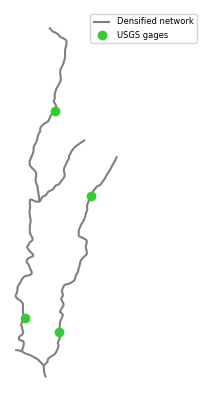

In [324]:
swsites = TCsites[0]
swsites = swsites.to_crs(den_streams_travis.crs)
# missingsite = swsites[swsites.site_no == '08157560']

fig, ax = plt.subplots(figsize = (5,5))
den_streams_travis.plot(ax = ax, color = 'gray', zorder = 1, label = 'Densified network')
swsites.plot(ax = ax, c = 'limegreen', zorder = 10, label = 'USGS gages')
# missingsite.plot(ax = ax, c = 'red', zorder = 15, label = 'Missing gage')
ax.axis('off')
plt.legend(loc = 'upper right', bbox_to_anchor=(1.7, 1), prop={'size': 6})

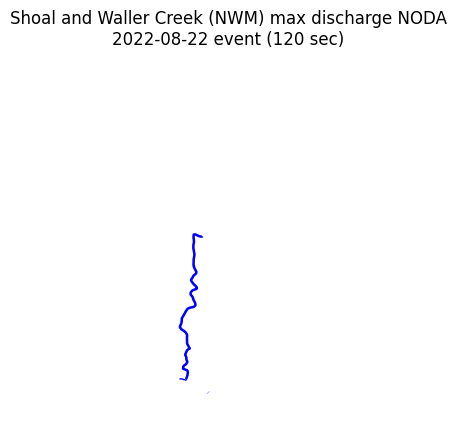

In [330]:
# take output from current time step and plot on the densified national water model stream network
fig, ax = plt.subplots()
den_streams_travis['flow'] = den_streams_travis['ID'].map(outputs_noda.max(axis=0)).fillna(0.).values
den_streams_travis.plot(ax=ax, color='b', zorder=3, 
                        linewidth=0.5*np.log(1 + den_streams_travis['flow'].values))
plt.title(ws_string + " max discharge NODA\n" + startdate_string + " event (" + num_sec + " sec)")
_ = plt.axis('off')
# plt.savefig('../figures/MaxDischarge_NODA_Den_' + num_sec + 'sec_' + startdate + '_' + ws + '.png', dpi=600)

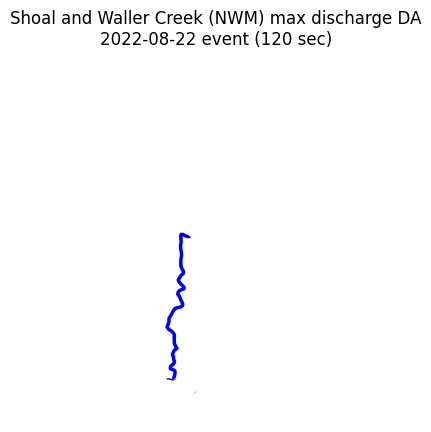

In [331]:
# take output from current time step and plot on the densified national water model stream network
fig, ax = plt.subplots()
den_streams_travis['flow'] = den_streams_travis['ID'].map(outputs_da.max(axis=0)).fillna(0.).values
den_streams_travis.plot(ax=ax, color='b', zorder=3, 
                        linewidth=0.5*np.log(1 + den_streams_travis['flow'].values))
plt.title(ws_string + " max discharge DA\n" + startdate_string + " event (" + num_sec + " sec)")
_ = plt.axis('off')
# plt.savefig('../figures/MaxDischarge_DA_Den_' + num_sec + 'sec_' + startdate + '_' + ws + '.png', dpi=600)

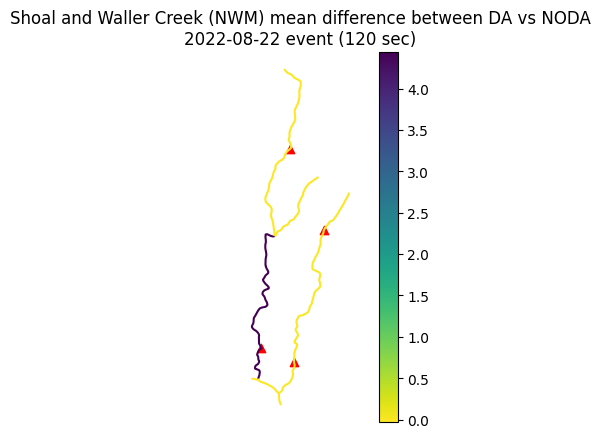

In [335]:
fig, ax = plt.subplots()
den_streams_travis.plot(column='gain', cmap='viridis_r', legend=True, ax = ax)
swsites[swsites.site_no != '08157560'].plot(c = 'red', marker = '^', ax = ax)
plt.title(ws_string + " mean difference between DA vs NODA\n" + startdate_string + " event (" + num_sec + " sec)")
_ = plt.axis('off')
# plt.savefig('../figures/MeanDifferenceDA_NODA_Den_' + num_sec + 'sec_' + startdate + '_' + ws + '.png', dpi=600)

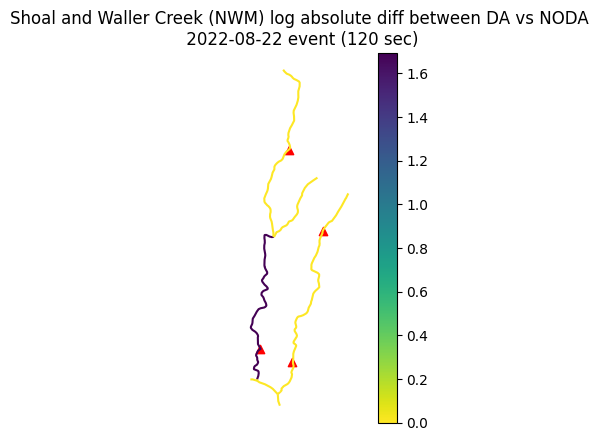

In [334]:
fig, ax = plt.subplots()
den_streams_travis.plot(column='log_gain', cmap='viridis_r', legend=True, ax = ax)
swsites[swsites.site_no != '08157560'].plot(c = 'red', marker = '^', ax = ax)
plt.title(ws_string + " log absolute diff between DA vs NODA\n " + startdate_string + " event (" + num_sec + " sec)")
_ = plt.axis('off')
# plt.savefig('../figures/LogAbsoluteDifferenceDA_NODA_Den_' + num_sec + 'sec_' + startdate + '_' + ws + '.png', dpi=600)

# Export peak flow data to csv 

In [271]:
# Organize and export model ouput data 
outputs = pd.concat([pd.DataFrame(outputs_da.max(), columns = ['q_cfs_da']), pd.DataFrame(outputs_noda.max(), columns = ['q_cfs_no_da'])], axis = 1)
outputs.index = outputs.index.astype(int)
outputs.index.name = 'ID'
print(outputs.index.name)
outputs = outputs * 35.314684921034 # convert back to cfs for ESRI geoprocessing 
# Save csv 
outputs.to_csv('../../DensiFIMcation/data/less_densified_model_qpeak_' + num_sec + 'sec_' + startdate + '_shoalwaller.csv')

ID


In [272]:
# Read csv output 
outputs = pd.read_csv('../../DensiFIMcation/data/less_densified_model_qpeak_' + num_sec + 'sec_' + startdate + '_shoalwaller.csv')
print(outputs)

       ID     q_cfs_da  q_cfs_no_da
0    3578     5.411491     5.411491
1    3579   431.345496   434.500909
2    3580  1206.624184  1398.341526
3    3581  2028.475046  2527.316426
4    3582    28.773957    28.802774
..    ...          ...          ...
123  3702  5714.244535  5465.163764
124  3704   221.407605   221.407605
125  3705   486.890167  2301.608465
126  3706   572.779286  2324.347926
127  3711  6328.858274  7163.013055

[128 rows x 3 columns]
